In [1]:
using LinearAlgebra

In [2]:
using Plots
using LaTeXStrings #Latex Syntax for Plotting

In [3]:
using ITensors
# ITensors.compile()

$$ H = -J\sum_{j = 1}^{N - 1}( b^{\dagger}_{j}b_{j+1} + h.c.)+\frac{U}{2} \sum_{j = 1}^{N} n_{j}(n_{j} - 1)$$

**Exact Diagonalization:**

In [39]:
function Create_Annihilation_Creation_Operators(N)
    # N is the Number of Bosons. Note: Creation is b† and annihilation is b.
    
    Creation = zeros(N+1, N+1) 
    for i=1:N
        Creation[i+1,i] = sqrt(i)
    end
    Annihilation = Adjoint(Creation)
    return Creation, Annihilation
end

function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity

    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

In [5]:
#Test: 
Creation, Annihilation = Create_Annihilation_Creation_Operators(3)
Identity = zeros(4,4)
for i=1:4
    Identity[i,i] = 1
end
kron(Identity,Creation) == Enlarge_Matrix_site_j(2,2,Creation)
kron(Identity,Creation, Annihilation) == Enlarge_Matrix_i_Matrix_j(2,3,3,Creation, Annihilation)

true

In [6]:
Creation

4×4 Matrix{Float64}:
 0.0  0.0      0.0      0.0
 1.0  0.0      0.0      0.0
 0.0  1.41421  0.0      0.0
 0.0  0.0      1.73205  0.0

In [40]:
function Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    H = zeros((N_Bosons+1)^L_Chain, (N_Bosons+1)^L_Chain)

    Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
    Particle_Number_Op = Creation*Annihilation

    for i=1:L_Chain-1
        j = i + 1 #nearest neighbor in 1D. Let's consider just OBC
        BdagB_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Creation, Annihilation)
        BBdag_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Annihilation, Creation)
        H = H -J*(BdagB_Term + BBdag_Term)
    end

    for i=1:L_Chain
        nini_Term =  Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op*Particle_Number_Op)
        ni_Term = Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op)
        H = H + 0.5*U*(nini_Term - ni_Term)
    end    

    return H
end

function Time_Evolution_Operator_ED(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

Time_Evolution_Operator_ED (generic function with 1 method)

In [8]:
H = Build_ED_Bose_Hubbard_Hamiltonian(3, 6, 1, 1)
Eigenvalues = eigen(H).values

4096-element Vector{Float64}:
 -9.48479861742051
 -9.355368957128752
 -9.276847906537574
 -8.930356840283165
 -8.672987764998894
 -8.379190815142868
 -8.337229057949354
 -8.244158663165601
 -8.054206185723405
 -7.9891491546176585
 -7.59079692649008
 -7.398754002944134
 -7.383563887995319
  ⋮
 21.552041784102897
 21.638733732371485
 21.742749315836093
 22.003406729257534
 22.619048826875883
 22.680775179505204
 22.94842339557522
 23.061207708702774
 23.5831113243445
 24.080837270141828
 24.56912961626505
 24.64852700401051

In [9]:
print(Eigenvalues[1], Eigenvalues[2], Eigenvalues[3])

-9.48479861742051-9.355368957128752-9.276847906537574

In [90]:
#Quantum Quench of Figure 1.

N_Bosons = 2 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

Hi = Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)
Hf = Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Uf)
#3 minutes to here.

Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
Correlation_Operator = Enlarge_Matrix_i_Matrix_j(1, 2, L_Chain, Creation, Annihilation)

# lambda_0 = eigen(Hi).values[1] 
Psi_0 = eigen(Hi).vectors[:,1] #16 min for this line

729-element Vector{Float64}:
  0.0
  2.972433056899084e-214
  2.289304401430468e-78
  1.755436464161696e-213
  1.2797646471304877e-77
 -5.69174032492168e-43
  2.3993997147568613e-77
 -1.3754260914344714e-42
  5.119609582349864e-22
  1.006987723401797e-212
  3.8409146585620245e-77
 -1.74887974498039e-42
  1.2133335538943973e-76
  ⋮
  8.28087579320387e-18
 -7.753574131298162e-18
  0.0
  1.3457811941271738e-17
 -1.7302062825887343e-17
  5.6915194026839584e-18
 -4.796243000115514e-19
  1.0513597598047637e-17
  2.3612221635523592e-64
  3.540105608038261e-18
  3.793249742614216e-66
  0.0

In [91]:
Times_ED = [0.0]
Correlations_ED = [Adjoint(Psi_0)*Correlation_Operator*Psi_0]

1-element Vector{Float64}:
 0.7243183649591955

In [92]:
dt = 0.1
U = Time_Evolution_Operator_ED(dt, Hf)
Psi_t = Psi_0

for i=1:20
    Psi_t = U*Psi_t
    Correlation = Adjoint(Psi_t)*Correlation_Operator*Psi_t
    append!(Correlations_ED, Correlation.re)
    append!(Times_ED, dt*i)
end

In [93]:
Correlations_ED

21-element Vector{Float64}:
  0.7243183649591955
 -0.04947322562696007
  0.2089918051699786
  0.5748936204364278
 -0.07473350300431775
  0.3900256942727903
  0.3257757180756913
  0.10393053142160034
  0.33716526560071447
  0.24226186459058813
  0.2104053904879751
  0.243164354212143
  0.2666688595228536
  0.18094868900482633
  0.2581255876204378
  0.2170261243246562
  0.17808204242635578
  0.28012673727295784
  0.11561291340195828
  0.2672647929505356
  0.19888535390030074

**Tensor Networks:**

In [54]:
function Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    sites = siteinds("Qudit",L_Chain, dim = N_Bosons + 1) #extra parameter: conserve_qns = true  
    # Input the operator terms 
    
    os = OpSum() 
    for i=1:L_Chain-1
        os += -J,"A",i,"Adag",i+1 
        os += -J,"Adag",i,"A",i+1 
    end 

    for i=1:L_Chain
        os += 0.5*U,"N * N",i
        os += -0.5*U,"N",i
    end 
    
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function TEBD_Time_Evolution_Expected_Value_Correlation(t, Psi_0, N_Bosons, L_Chain, J, U, site_inds)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    N = length(Psi_0)
    
    cutoff = 1E-8
    dt = 0.1
    
    s = site_inds
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        #First Attemp:
        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end

        #Second Attemp:
        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    Correlation_Values = [correlation_matrix(Psi_0,"Adag","A")[1,2]] 
    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff)
        normalize!(Psi_t)

        append!(Times, time)
        append!(Correlation_Values, correlation_matrix(Psi_t,"Adag","A")[1,2].re)
    end
    
    return Correlation_Values, Times
end

TEBD_Time_Evolution_Expected_Value_Correlation (generic function with 1 method)

In [11]:
H_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(3,6,1,1)

nsweeps = 10
maxdim = [10,20,100,200,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(H_MPO,randomMPS(sites,4); nsweeps, maxdim, cutoff) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1
energy_1_excited_state, psi_1_excited_state = dmrg(H_MPO,[psi_ground_state], randomMPS(sites,4); nsweeps, maxdim, cutoff) 
energy_2_excited_state, psi_2_excited_state = dmrg(H_MPO,[psi_ground_state, psi_1_excited_state], randomMPS(sites,4); nsweeps, maxdim, cutoff) 

After sweep 1 energy=-9.278177087888508  maxlinkdim=10 maxerr=3.70E-03 time=13.231
After sweep 2 energy=-9.459640110507083  maxlinkdim=20 maxerr=7.00E-07 time=0.047
After sweep 3 energy=-9.475800264208216  maxlinkdim=48 maxerr=9.69E-11 time=0.127
After sweep 4 energy=-9.484354607593012  maxlinkdim=48 maxerr=8.60E-11 time=0.201
After sweep 5 energy=-9.484759213479977  maxlinkdim=43 maxerr=9.40E-11 time=0.175
After sweep 6 energy=-9.4847942315601  maxlinkdim=40 maxerr=9.38E-11 time=0.136
After sweep 7 energy=-9.484798385620225  maxlinkdim=39 maxerr=7.52E-11 time=0.114
After sweep 8 energy=-9.484798610409758  maxlinkdim=38 maxerr=9.64E-11 time=0.127
After sweep 9 energy=-9.484798616215576  maxlinkdim=38 maxerr=7.75E-11 time=0.099
After sweep 10 energy=-9.484798616389247  maxlinkdim=38 maxerr=6.77E-11 time=0.104
After sweep 1 energy=-9.033549826049029  maxlinkdim=10 maxerr=1.42E-03 time=0.212
After sweep 2 energy=-9.266520052346792  maxlinkdim=20 maxerr=1.26E-06 time=0.030
After sweep 3 en

(-9.278159952755809, MPS
[1] ((dim=4|id=413|"Link,l=1"), (dim=4|id=948|"Qudit,Site,n=1"))
[2] ((dim=16|id=154|"Link,l=2"), (dim=4|id=298|"Qudit,Site,n=2"), (dim=4|id=413|"Link,l=1"))
[3] ((dim=4|id=68|"Qudit,Site,n=3"), (dim=36|id=148|"Link,l=3"), (dim=16|id=154|"Link,l=2"))
[4] ((dim=4|id=833|"Qudit,Site,n=4"), (dim=16|id=279|"Link,l=4"), (dim=36|id=148|"Link,l=3"))
[5] ((dim=4|id=913|"Qudit,Site,n=5"), (dim=4|id=463|"Link,l=5"), (dim=16|id=279|"Link,l=4"))
[6] ((dim=4|id=358|"Qudit,Site,n=6"), (dim=4|id=463|"Link,l=5"))
)

In [12]:
# ? randomMPS #Important if we want to include the conservation of nqs

In [13]:
print(Eigenvalues[1], Eigenvalues[2], Eigenvalues[3]) #Using ED

-9.48479861742051-9.355368957128752-9.276847906537574

In [14]:
println(energy_ground_state, energy_1_excited_state, energy_2_excited_state) #Using ITensors

-9.484798616389247-9.353868632235045-9.278159952755809


In [94]:
#Quantum Quench of Figure 1.

N_Bosons = 2 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)

nsweeps = 10
maxdim = [10,20,100,200,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,N_Bosons+1); nsweeps, maxdim, cutoff) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-5.655110454563297  maxlinkdim=10 maxerr=1.43E-04 time=0.008
After sweep 2 energy=-5.895489520686641  maxlinkdim=20 maxerr=1.00E-07 time=0.010
After sweep 3 energy=-5.903168873429344  maxlinkdim=25 maxerr=9.47E-11 time=0.014
After sweep 4 energy=-5.903516045563867  maxlinkdim=24 maxerr=8.76E-11 time=0.019
After sweep 5 energy=-5.90385883750094  maxlinkdim=24 maxerr=4.93E-11 time=0.014
After sweep 6 energy=-5.904184005694012  maxlinkdim=23 maxerr=8.21E-11 time=0.020
After sweep 7 energy=-5.9044663926471195  maxlinkdim=22 maxerr=9.17E-11 time=0.015
After sweep 8 energy=-5.904714928006431  maxlinkdim=22 maxerr=4.86E-11 time=0.013
After sweep 9 energy=-5.904928597324323  maxlinkdim=21 maxerr=7.34E-11 time=0.016
After sweep 10 energy=-5.905098156481661  maxlinkdim=21 maxerr=6.59E-11 time=0.012


(-5.905098156481661, MPS
[1] ((dim=3|id=506|"Link,l=1"), (dim=3|id=914|"Qudit,Site,n=1"))
[2] ((dim=9|id=144|"Link,l=2"), (dim=3|id=367|"Qudit,Site,n=2"), (dim=3|id=506|"Link,l=1"))
[3] ((dim=3|id=696|"Qudit,Site,n=3"), (dim=21|id=915|"Link,l=3"), (dim=9|id=144|"Link,l=2"))
[4] ((dim=3|id=20|"Qudit,Site,n=4"), (dim=9|id=544|"Link,l=4"), (dim=21|id=915|"Link,l=3"))
[5] ((dim=3|id=412|"Qudit,Site,n=5"), (dim=3|id=43|"Link,l=5"), (dim=9|id=544|"Link,l=4"))
[6] ((dim=3|id=961|"Qudit,Site,n=6"), (dim=3|id=43|"Link,l=5"))
)

In [95]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, N_Bosons, L_Chain, J, Uf, sites)

([0.731267492192172, -0.07329280994208669, 0.1721329157234432, 0.6202125216510557, -0.16789158334518614, 0.39168995835750986, 0.38180457824937786, -0.07186206866493627, 0.44980578419882905, 0.1954141299213538  …  0.3708639973852652, 0.1460609866541569, 0.21050994277792082, 0.2718808404536614, 0.18144861118743083, 0.2382712680240084, 0.22660102093435391, 0.21085058150766606, 0.232928258169685, 0.22184775721638708], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])

In [96]:
#Comparison
Correlations_ED

21-element Vector{Float64}:
  0.7243183649591955
 -0.04947322562696007
  0.2089918051699786
  0.5748936204364278
 -0.07473350300431775
  0.3900256942727903
  0.3257757180756913
  0.10393053142160034
  0.33716526560071447
  0.24226186459058813
  0.2104053904879751
  0.243164354212143
  0.2666688595228536
  0.18094868900482633
  0.2581255876204378
  0.2170261243246562
  0.17808204242635578
  0.28012673727295784
  0.11561291340195828
  0.2672647929505356
  0.19888535390030074

In [97]:
Correlations_TEBD

21-element Vector{Float64}:
  0.731267492192172
 -0.07329280994208669
  0.1721329157234432
  0.6202125216510557
 -0.16789158334518614
  0.39168995835750986
  0.38180457824937786
 -0.07186206866493627
  0.44980578419882905
  0.1954141299213538
  0.09769517334301694
  0.3708639973852652
  0.1460609866541569
  0.21050994277792082
  0.2718808404536614
  0.18144861118743083
  0.2382712680240084
  0.22660102093435391
  0.21085058150766606
  0.232928258169685
  0.22184775721638708

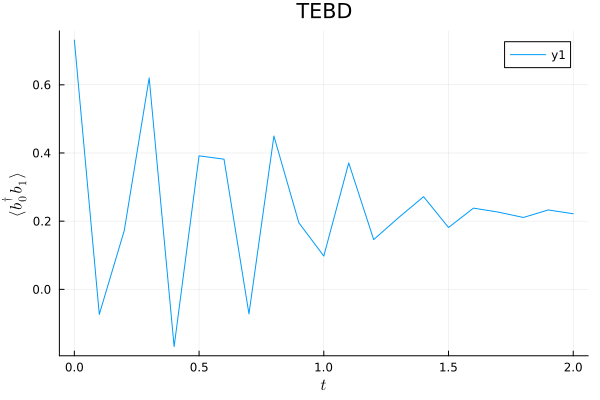

In [98]:
plot(Times_TEBD, Correlations_TEBD)
xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("TEBD")

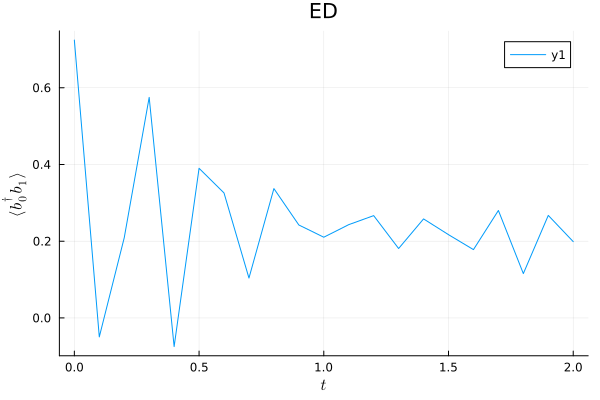

In [99]:
plot(Times_ED, Correlations_ED)
xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("ED")

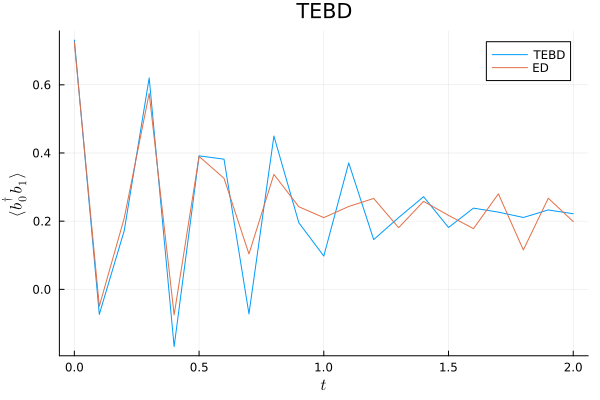

In [102]:
plot(Times_TEBD, Correlations_TEBD, label = "TEBD")
plot!(Times_ED, Correlations_ED, label = "ED")

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("TEBD")

In [103]:
#Quantum Quench of Figure 1.

N_Bosons = 9
L_Chain = 64 
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)

nsweeps = 10
maxdim = [10,20,100,200,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,N_Bosons+1); nsweeps, maxdim, cutoff) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-58.23988140366199  maxlinkdim=10 maxerr=2.28E-02 time=3.395
After sweep 2 energy=-77.60207895314872  maxlinkdim=20 maxerr=1.50E-05 time=7.751
After sweep 3 energy=-79.2300174644277  maxlinkdim=67 maxerr=9.99E-11 time=18.195
After sweep 4 energy=-80.06563610318041  maxlinkdim=83 maxerr=1.00E-10 time=22.305
After sweep 5 energy=-80.82246848229873  maxlinkdim=69 maxerr=9.97E-11 time=21.323
After sweep 6 energy=-81.49409876430796  maxlinkdim=85 maxerr=9.99E-11 time=21.288
After sweep 7 energy=-82.00161656613162  maxlinkdim=88 maxerr=9.98E-11 time=20.371
After sweep 8 energy=-82.50547352899784  maxlinkdim=67 maxerr=9.93E-11 time=18.951
After sweep 9 energy=-82.96973555192469  maxlinkdim=66 maxerr=9.99E-11 time=18.271
After sweep 10 energy=-83.35308396846939  maxlinkdim=59 maxerr=9.93E-11 time=17.436


(-83.35308396846939, MPS
[1] ((dim=10|id=326|"Link,l=1"), (dim=10|id=115|"Qudit,Site,n=1"))
[2] ((dim=21|id=228|"Link,l=2"), (dim=10|id=663|"Qudit,Site,n=2"), (dim=10|id=326|"Link,l=1"))
[3] ((dim=10|id=142|"Qudit,Site,n=3"), (dim=31|id=853|"Link,l=3"), (dim=21|id=228|"Link,l=2"))
[4] ((dim=10|id=986|"Qudit,Site,n=4"), (dim=35|id=966|"Link,l=4"), (dim=31|id=853|"Link,l=3"))
[5] ((dim=10|id=29|"Qudit,Site,n=5"), (dim=34|id=343|"Link,l=5"), (dim=35|id=966|"Link,l=4"))
[6] ((dim=10|id=655|"Qudit,Site,n=6"), (dim=40|id=261|"Link,l=6"), (dim=34|id=343|"Link,l=5"))
[7] ((dim=10|id=162|"Qudit,Site,n=7"), (dim=39|id=847|"Link,l=7"), (dim=40|id=261|"Link,l=6"))
[8] ((dim=10|id=121|"Qudit,Site,n=8"), (dim=39|id=722|"Link,l=8"), (dim=39|id=847|"Link,l=7"))
[9] ((dim=10|id=532|"Qudit,Site,n=9"), (dim=41|id=575|"Link,l=9"), (dim=39|id=722|"Link,l=8"))
[10] ((dim=10|id=946|"Qudit,Site,n=10"), (dim=43|id=915|"Link,l=10"), (dim=41|id=575|"Link,l=9"))
[11] ((dim=10|id=784|"Qudit,Site,n=11"), (dim=39|id

In [ ]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, N_Bosons, L_Chain, J, Uf, sites)

In [ ]:
plot(Times_TEBD, Correlations_TEBD)
xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("L = 64 using TEBD")